In [119]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
import sklearn
np.random.seed(42)

Changes from previous version: I am using all of the (CDR3) data (20,000) as compared to a subset (2,000)

In [120]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [121]:
tf.__version__

'2.10.0'

# Preprocessing

In [1]:
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    head = [next(myfile) for x in range(23734)]
print(head[1])

AACCTACTGGAGTCTGGGGGAGGCTTAGTCAAGCCAGGAGGGTCCCTGAGACTGTCTTGTGAAGGCTCAGGATTCCTGTTCAGTCACTATTACATGAGTTGGATACGCCAGGGTCCCGAGAAGAGACTGGAGTTGGTTGCATACATTAGCTCCAATAGTACCGCCTTTTATTACGCAGACTCTGTGAAGGGCCGCTTCACCGTTTCCAAGGACGACGCCAAGAAGTCTGTGTTTCTCCAAATGACTTCCGTGTCAAGCGACGACACGGCCACCTATTACTGTGCGACGGGGGATTGGAGTCGTACCAATAACTTCGACACCTGGGGCCAGGGAACCCAGGTCATCGTCTCC



In [123]:
healthy_sequences = []
for i in head:
    if i.find("cdr3_aa_seq=") == -1:
        continue
    inner_str = i.split('cdr3_aa_seq=')[-1].split('size=')[0]
    healthy_sequences.append(inner_str)

In [124]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["CDRH3"]]

In [125]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

# print(covid_sequences)

30
32


In [126]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [127]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((32, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((32, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

# set infected 1, healthy 0

11867


In [131]:
healthy_lables = [0] * 11867
covid_lables = [1] * 11867

In [132]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Model

In [134]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-11-20 23:26:39.543387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 23:26:39.543536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [135]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [143]:
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val))

Epoch 1/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 1.4000 - val_accuracy: 0.7879
Epoch 2/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0146 - accuracy: 0.9950 - val_loss: 1.4527 - val_accuracy: 0.7865
Epoch 3/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0118 - accuracy: 0.9960 - val_loss: 1.3776 - val_accuracy: 0.7912
Epoch 4/100
601/601 [==============================] - 5s 8ms/step - loss: 0.0144 - accuracy: 0.9948 - val_loss: 1.3750 - val_accuracy: 0.7935
Epoch 5/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0121 - accuracy: 0.9957 - val_loss: 1.5089 - val_accuracy: 0.7917
Epoch 6/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 1.5957 - val_accuracy: 0.8006
Epoch 7/100
601/601 [==============================] - 5s 9ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 1.4510 - val_accuracy: 0.7945

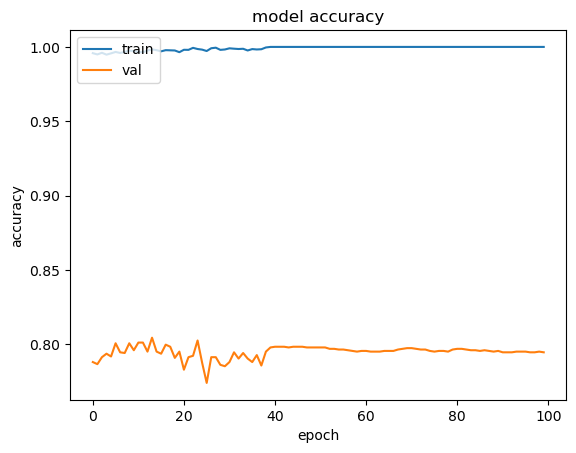

In [144]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing

In [145]:
model.evaluate(X_test, y_test)

75/75 [==============================] - 0s 4ms/step - loss: 5.3592 - accuracy: 0.7949


[5.359197616577148, 0.7948610186576843]

In [146]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 13ms/step


[array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

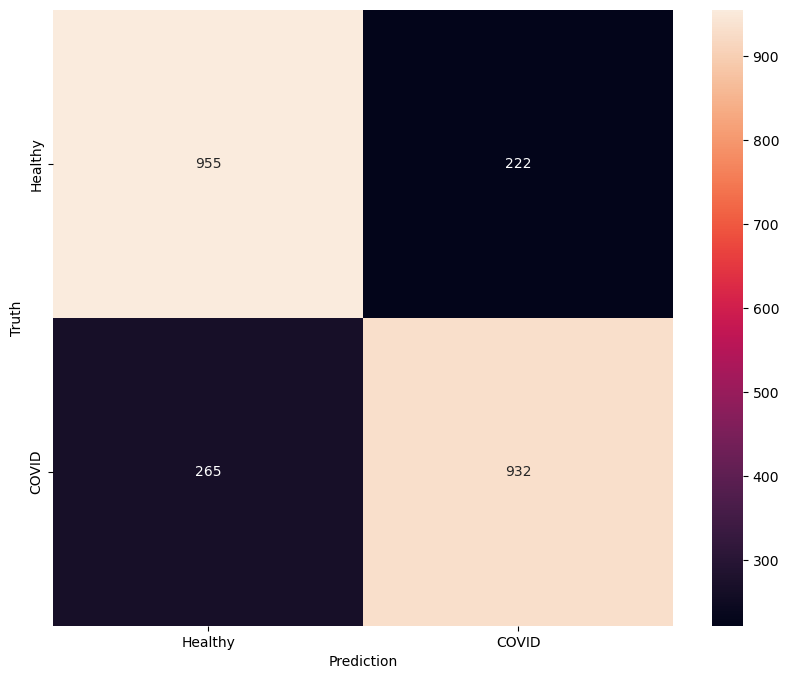

tf.Tensor(
[[955 222]
 [265 932]], shape=(2, 2), dtype=int32)


In [147]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [148]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

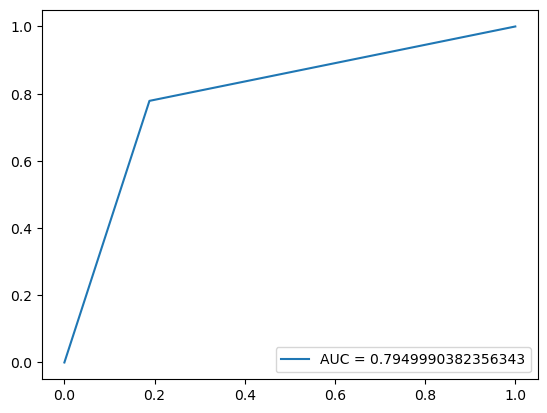

In [149]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()